In [64]:
# Facebook Prophet Template

# import libraries

In [1]:
!conda activate stan_env

In [3]:
#import libraries
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [4]:
#get the data
data = pd.read_csv("Daily Bike Sharing.csv")
data.head(1)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985


In [5]:
#select variables
dataset = data.loc[:,["dteday","cnt", "holiday", "workingday", "weathersit",
                      "temp", "atemp", "hum", "windspeed"]]
dataset.head(1)

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


# Data Transformation

In [6]:
#Date variable 
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [15]:
#renaming variable
dataset = dataset.rename(columns = {"cnt" : "y"})
dataset = dataset.rename(columns = {"dteday" : "ds"})
dataset.head(1)

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446


# Holidays 

In [18]:
holiday_dates = dataset[dataset.holiday==1].ds
holidays = pd.DataFrame({'holiday' : 'holi', 
                        'ds': pd.to_datetime(holiday_dates),
                        'lower_window': -3,
                        'upper_window': 1})
holidays.head(1)

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1


In [19]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


# Training and Test Set

In [20]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
730,2012-12-31,2729,1,2,0.215833,0.223487,0.5775,0.154846


# Facebook Prophet

In [24]:
#Facebook Prophet model
m = Prophet(growth = "linear",
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = "multiplicative",
           seasonality_prior_scale = 10,
           holidays_prior_scale = 10,
           changepoint_prior_scale = 0.05)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

17:18:48 - cmdstanpy - INFO - Chain [1] start processing
17:18:49 - cmdstanpy - INFO - Chain [1] done processing


# Forecasting

In [33]:
#create future dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [34]:
#merge regressors 
future = pd.concat([future, dataset.iloc[:,2:]],
                  axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [35]:
# Forecast
forecast = m.predict(future)
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,1721.860258,99.213316,1910.753363,1721.860258,1721.860258,-0.038856,-0.038856,-0.038856,-0.302283,...,0.0,0.0,0.0,-0.272341,-0.272341,-0.272341,0.0,0.0,0.0,979.959663


In [36]:
#predictions 
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

700    4173.602415
701    3509.660639
702    5697.921503
703    5704.213384
704    5397.463439
Name: prophet, dtype: float64

# Visualization 

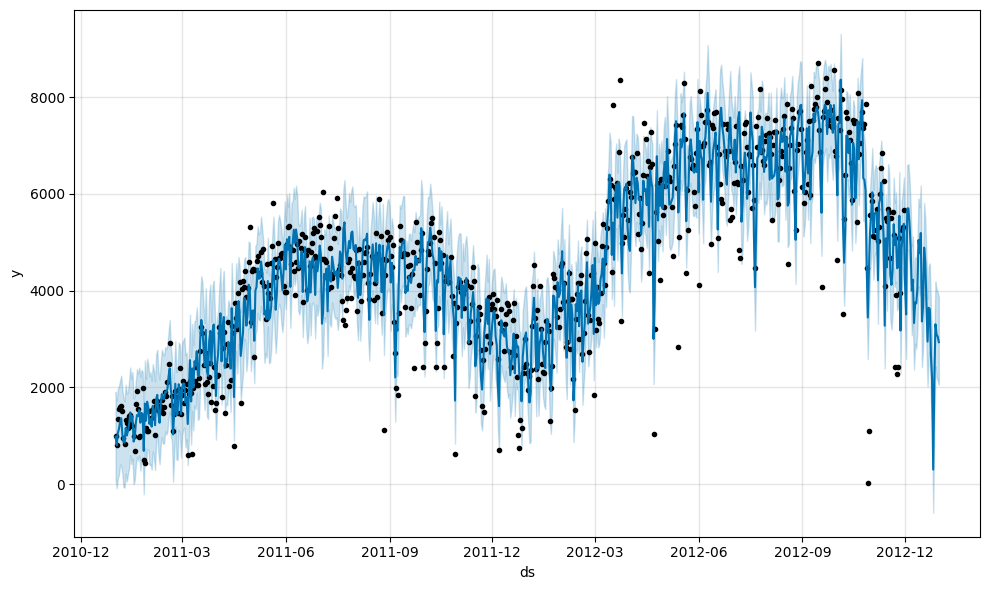

In [37]:
#visualization
m.plot(forecast);

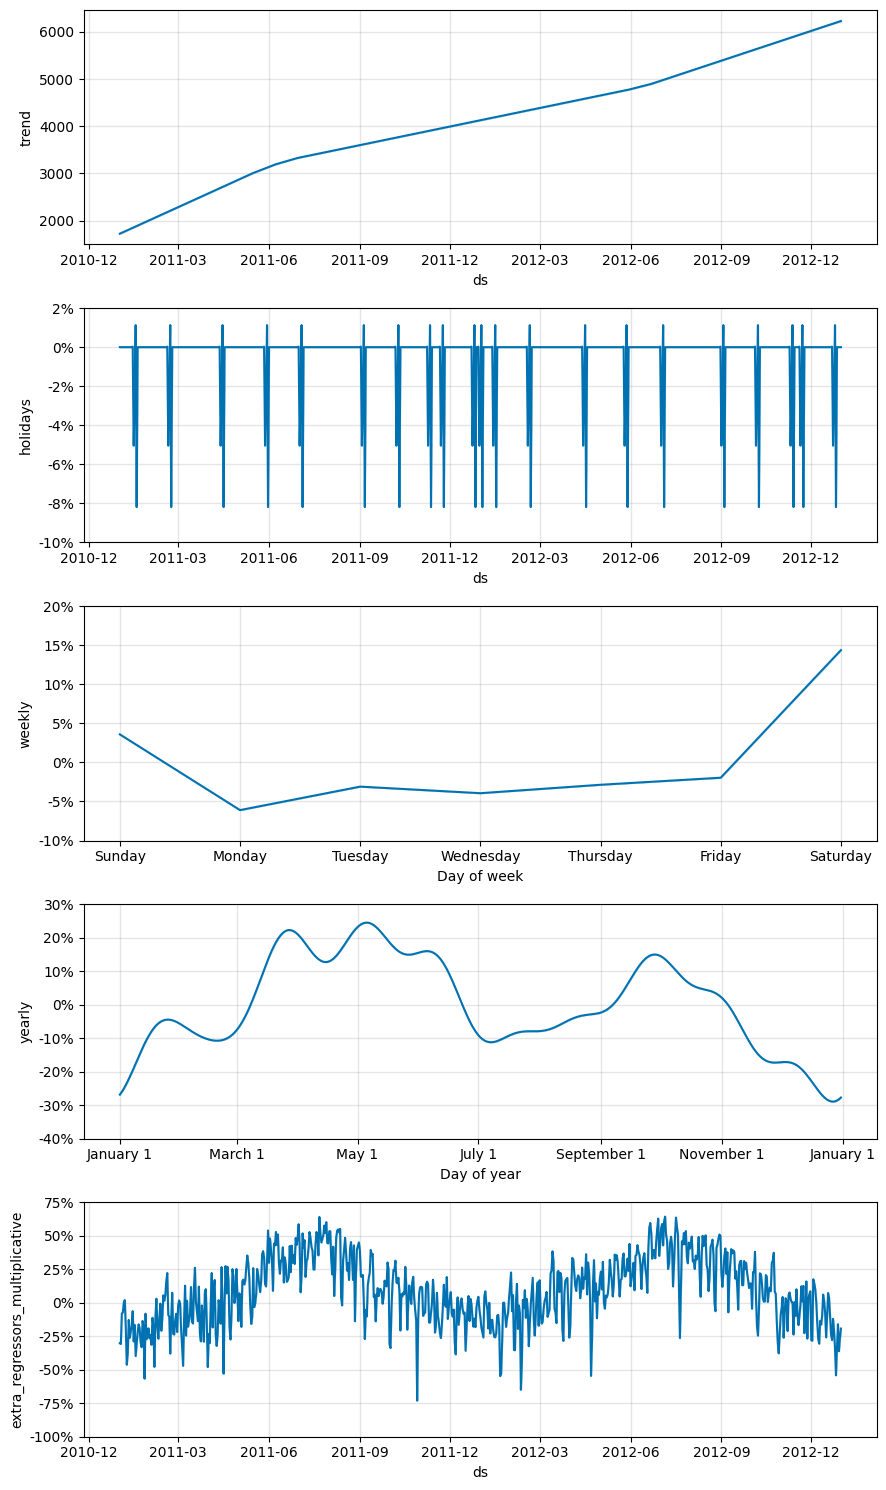

In [39]:
#plot components
m.plot_components(forecast);

# Model Assessment

In [46]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)),0))

862.0
1030.0


In [41]:
#MAPE function
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

34.96593287691537

# Cross Validation

In [47]:
#CV
from prophet.diagnostics import cross_validation 
df_cv = cross_validation(m,
                        horizon = '31 days',
                        initial = '540 days',
                        parallel = "processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-06-29,8183.857358,7458.114125,8953.867724,5463,2012-06-28
1,2012-06-30,7257.470364,6470.250492,8011.305583,5687,2012-06-28
2,2012-07-01,7443.773319,6685.548193,8230.774683,5531,2012-06-28
3,2012-07-02,6794.063654,6028.321419,7601.850236,6227,2012-06-28
4,2012-07-03,7460.865320,6746.925839,8215.678308,6660,2012-06-28


In [48]:
#MAE and RMSE
print(round(mean_absolute_error(df_cv['y'], df_cv['yhat']),0))
print(round(np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat'])),0))
print(MAPE(df_cv['y'], df_cv['yhat']))

1006.0
1266.0
126.81772533728599


# Hyperparameter Tuning

In [52]:
#Parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale':[5, 10, 20],
             'holidays_prior_scale':[5, 10, 20],
             'changepoint_prior_scale':[0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [53]:
#Hyper parameter tuning
rsme = []
for params in grid:
    #build model
    m = Prophet(growth = "linear",
           yearly_seasonality = True,
           weekly_seasonality = True,
           daily_seasonality = False,
           holidays = holidays,
           seasonality_mode = "multiplicative",
           seasonality_prior_scale = params['seasonality_prior_scale'],
           holidays_prior_scale = params['holidays_prior_scale'],
           changepoint_prior_scale = params['changepoint_prior_scale'])
    m.add_regressor('workingday')
    m.add_regressor('weathersit')
    m.add_regressor('temp')
    m.add_regressor('atemp')
    m.add_regressor('hum')
    m.add_regressor('windspeed')
    m.fit(training_set) 

    #cross-validation 
    df_cv = cross_validation(m,
                        horizon = '31 days',
                        initial = '540 days',
                        parallel = "processes")
    #gather results
    error = np.sqrt(mean_squared_error(df_cv['y'], 
                                       df_cv['yhat']))
    rsme.append(error)

19:36:32 - cmdstanpy - INFO - Chain [1] start processing
19:36:32 - cmdstanpy - INFO - Chain [1] done processing
19:36:42 - cmdstanpy - INFO - Chain [1] start processing
19:36:42 - cmdstanpy - INFO - Chain [1] done processing
19:36:51 - cmdstanpy - INFO - Chain [1] start processing
19:36:52 - cmdstanpy - INFO - Chain [1] done processing
19:37:01 - cmdstanpy - INFO - Chain [1] start processing
19:37:01 - cmdstanpy - INFO - Chain [1] done processing
19:37:11 - cmdstanpy - INFO - Chain [1] start processing
19:37:11 - cmdstanpy - INFO - Chain [1] done processing
19:37:20 - cmdstanpy - INFO - Chain [1] start processing
19:37:20 - cmdstanpy - INFO - Chain [1] done processing
19:37:30 - cmdstanpy - INFO - Chain [1] start processing
19:37:30 - cmdstanpy - INFO - Chain [1] done processing
19:37:39 - cmdstanpy - INFO - Chain [1] start processing
19:37:39 - cmdstanpy - INFO - Chain [1] done processing
19:37:49 - cmdstanpy - INFO - Chain [1] start processing
19:37:49 - cmdstanpy - INFO - Chain [1]

In [54]:
#best parameters
best_params = grid[np.argmin(rsme)]
print(best_params)

{'seasonality_prior_scale': 10, 'holidays_prior_scale': 10, 'changepoint_prior_scale': 0.01}


# Final Prophet model 

In [55]:
#build model
m = Prophet(growth = "linear",
       yearly_seasonality = True,
       weekly_seasonality = True,
       daily_seasonality = False,
       holidays = holidays,
       seasonality_mode = "multiplicative",
       seasonality_prior_scale = best_params['seasonality_prior_scale'],
       holidays_prior_scale = best_params['holidays_prior_scale'],
       changepoint_prior_scale = best_params['changepoint_prior_scale'])
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set) 

19:46:41 - cmdstanpy - INFO - Chain [1] start processing
19:46:41 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
#create future dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                freq = "D")
future.tail(1)

,ds
730,2012-12-31


In [57]:
#merge regressors 
future = pd.concat([future, dataset.iloc[:,2:]],
                  axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [58]:
# Forecast
forecast = m.predict(future)
forecast.head(1)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2465.948718,394.24134,2218.819008,2465.948718,2465.948718,-0.055428,-0.055428,-0.055428,-0.285086,...,0.0,0.0,0.0,-0.259063,-0.259063,-0.259063,0.0,0.0,0.0,1262.416672


In [62]:
#predictions 
predictions_prophet_tuned = forecast.yhat[-test_days:].rename("prophet_tuned")
predictions_prophet_tuned.index = test_set["ds"]
predictions_prophet_tuned[:5]

ds
2012-12-01    4100.964481
2012-12-02    3470.005832
2012-12-03    5616.608825
2012-12-04    5610.054326
2012-12-05    5319.594786
Name: prophet_tuned, dtype: float64

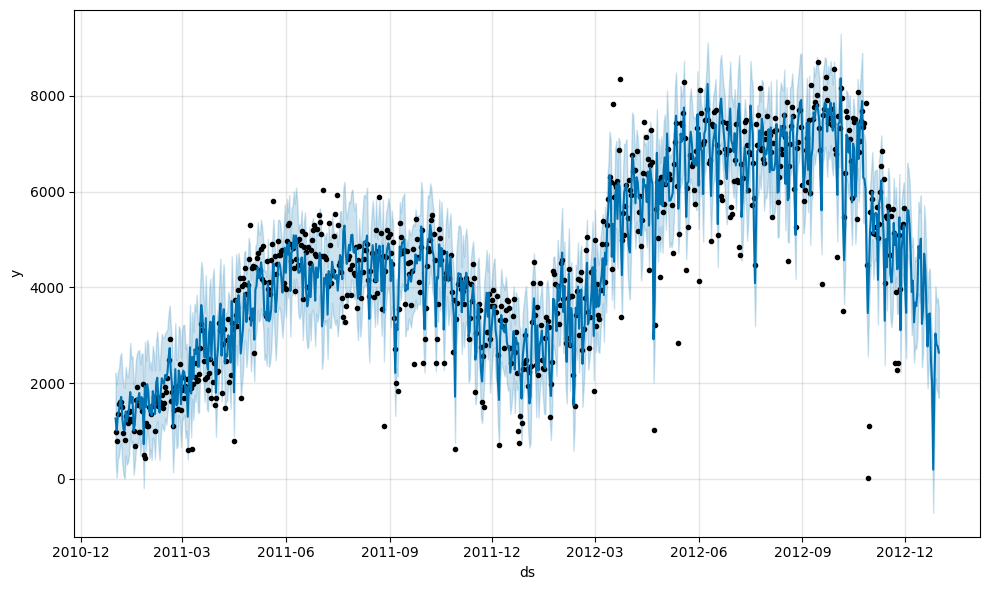

In [63]:
#visualization
m.plot(forecast);